In [1]:
from __future__ import division, print_function, absolute_import
from string import Template
import textwrap
import sys
import numpy as np
import os

# SETTINGS
INPUT_SIZE = 32
BLOCKS = 5 #共有多少个模块个数
COLUMNS = 3 #分形的迭代次数，亦即每个模块内的通路个数
CLASSES = 10
GLOBAL_DROP_PATH = False

FILTERS = [64, 128, 256, 512, 512]

COLORS = dict(black='0;30', darkgray='1;30', red='1;31', green='1;32',
              brown='0;33', yellow='1;33', blue='1;34', purple='1;35', cyan='1;36',
              white='1;37', reset='0')
DEFAULT_COLORIZE = False

定义了函数生成corx.prototxt文件

In [2]:
def paint(s, color, colorize=DEFAULT_COLORIZE):
    if colorize:
        if color in COLORS:
            return '\033[{}m{}\033[0m'.format(COLORS[color], s)
        else:
            raise ValueError('Invalid color')
    else:
        return s

def conv(depth, red, num, dropout=0, bottom=None, separate=False):
    top = 'conv{}_{}'.format(depth, red)
    d = {}
    d['name'] = top
    if separate:
        top = 's_' + top
    d['top'] = top
    d['bottom'] = bottom
    d['num'] = num
    d['size'] = 3
    d['dropout'] = dropout
    d['pad'] = 1
    d['func'] = paint('conv', 'green')
    s = Template(":call $func $name $dropout $size $pad $num $bottom $top").substitute(d)
    return s, top

def pool(depth, red, bottom=None, separate=False):
    top = 'pool{}_{}'.format(depth, red)
    d = {}
    if separate:
        top = 's_' + top
    d['top'] = top
    d['bottom'] = bottom
    d['func'] = paint('pool2', 'purple')
    s = Template(":call $func $bottom $top").substitute(d)
    return s, top


def join(depth, red, bottoms=[]):
    top = bottoms[-1] + '_plus'
    d = {}
    d['top'] = top
    d['bottoms'] = '\n'.join('  bottom: {}'.format(b) for b in bottoms)
    d['bottoms_flat'] = ' '.join(bottoms)
    d['func'] = paint('join%d' % len(bottoms), 'yellow')
    s = Template(":call $func $bottoms_flat $top").substitute(d)
    return s, top


def inner(col, num, bottom=None, separate=False):
    top = 'prediction{}'.format(col)
    d = {}
    d['name'] = 'prediction0'
    if separate:
        top = 's_'+top
    d['top'] = top
    d['bottom'] = bottom
    d['num'] = num
    d['func'] = paint('inner', 'cyan')
    s = Template(":call $func $name $num $bottom $top").substitute(d)
    return s, top


def loss(col, weight, label, bottom=None, separate=False):
    if separate:
        top = 's_loss{}'.format(col)
    else:
        top = 'loss{}'.format(col)
    d = {}
    d['top'] = top
    d['bottom'] = bottom
    d['label'] = label
    d['weight'] = weight
    d['func'] = paint('loss', 'red')
    s = Template(":call $func $weight $bottom $label $top").substitute(d)
    return s, top

# Do one or two passes (two passes are used for tied global drop-path using separate columns)
PASSES = [False]
if GLOBAL_DROP_PATH:
    PASSES += [True]
    
replacements = {}

def get_rep(s):
    global replacements
    if s not in replacements:
        return s
    else:
        return get_rep(replacements[s])

def set_rep(c, r, value):
    global replacements
    replacements['{}_{}'.format(c, r)] = value

## 路径调节
给每一个Blocks增加一个路径选择的设置，即每个block内有若干条通路可以选择， 目前还没有实现所有通路的覆盖，只有columns条

In [3]:
def fractalnet(model):
    
    filename = './cifar10/fractalNet/test4/phase_{}.crox.prototxt'.format(model)
    f = open(filename, 'w+') 
    
    columns = [[] for _ in range(COLUMNS)]
    print(':include ./test4/globals_{}.crox'.format(model),file = f)
    print(':call load-data data label', file = f)
    print(paint('# Input size: {}'.format(INPUT_SIZE), 'darkgray'), file = f)
    
    for separate in PASSES:
        lasts = ['data',] * COLUMNS
        ordinals = [0] * COLUMNS
        for r in range(BLOCKS):
            filters = FILTERS[r]
            path = PATHMATRIX[model][r]

            L = 2**(COLUMNS - 1)
            for l in range(L):
                for c in reversed(range(COLUMNS)):
                    minus_c = COLUMNS - c
                    if (l + 1) % 2**(minus_c - 1) == 0:
                        s, lasts[c] = conv(c, ordinals[c], filters, dropout=path[c], bottom=lasts[c], separate=separate)
                        ordinals[c] += 1
                        print(s,file = f)

                if l == L - 1:
                    for c in range(COLUMNS):
                        s, lasts[c] = pool(c, ordinals[c] - 1, bottom=lasts[c], separate=separate)
                        print(s,file = f)
    
                if not separate:
                    for c in range(COLUMNS):
                        if l % 2 ** (2 + c) == 2 ** (1 + c) - 1:
                            num = 2 + c
                            s, last = join(c, ordinals[c], bottoms=lasts[-num:])
                            for i in range(COLUMNS-num, COLUMNS):
                                lasts[i] = last
                            print(s,file = f)
                            break
    
            print(paint('# Reduction: {}, spatial size: {}'.format(r+1, INPUT_SIZE // 2**(r+1)), 'darkgray'),file = f)
            
        if not separate:
            s, lasts[0] = inner(col=0, num=CLASSES, bottom=lasts[0], separate=separate)
            print(s,file = f)
    
            s, lasts[0] = loss(0, 1.0, 'label', bottom=lasts[0], separate=separate)
            print(s,file = f)
    
        else:
            for c in range(COLUMNS):
                s, lasts[c] = inner(c, CLASSES, bottom=lasts[c], separate=separate)
                print(s,file = f)
    
                s, lasts[c] = loss(c, 1/COLUMNS, 'label', bottom=lasts[c], separate=separate)
                print(s,file = f)
            
    

### 路径设计
前三个矩阵代表了训练的三个stage,每一列代表每一个colomn在不同训练阶段的dropout ratio，矩阵中行代表的是一个block，三个矩阵代表三个block的dropout ratio，此处其实是原论文中global droppath的一种实现。

In [4]:
PATHMATRIX = [[[0,0,0],[0.1,0.1,0.1],[0.2,0.2,0.2],[0.3,0.3,0.3],[0.4,0.4,0.4]],
              [[0,0,0],[0.1,0.1,0.1],[0.2,0.2,0.2],[0.3,0.3,0.3],[0.4,0.4,0.4]],
              [[0,0,0],[0.1,0.1,0.1],[0.2,0.2,0.2],[0.3,0.3,0.3],[0.4,0.4,0.4]],
              [[0,0,0],[0.1,0.1,0.1],[0.2,0.2,0.2],[0.3,0.3,0.3],[0.4,0.4,0.4]]]

In [5]:
fractalnet(0)
fractalnet(1)
fractalnet(2)
fractalnet(3)

输出的是UTF-8格式的crox.prototxt文件，此时我们还需要将这些文件转化成fractaltext文件

In [6]:
os.chdir('./cifar10/fractalNet') 

In [7]:
! python core.py ./test4/phase_0.crox.prototxt > ./test4/phase_0.prototxt
! python core.py ./test4/phase_1.crox.prototxt > ./test4/phase_1.prototxt
! python core.py ./test4/phase_2.crox.prototxt > ./test4/phase_2.prototxt
! python core.py ./test4/phase_3.crox.prototxt > ./test4/phase_3.prototxt

In [8]:
os.chdir('test4')

In [9]:
import caffe

# 使输出的参数完全显示
# 若没有这一句，因为参数太多，中间会以省略号“……”的形式代替
np.set_printoptions(threshold='nan')
from pylab import *
import matplotlib.pyplot as plt

# 设置为gpu模式
caffe.set_device(0)
caffe.set_mode_gpu()

In [10]:
solverRoot0 = 'cifar10_fractalNet_solver_phase0.prototxt'
solverRoot1 = 'cifar10_fractalNet_solver_phase1.prototxt'
solverRoot2 = 'cifar10_fractalNet_solver_phase2.prototxt'
solverRoot3 = 'cifar10_fractalNet_solver_phase3.prototxt'
solverRoot4 = 'cifar10_fractalNet_solver_phase4.prototxt'
if os.path.isfile(solverRoot1):
    print('solverRoot0 found')
    
if os.path.isfile(solverRoot1):
    print('solverRoot1 found')
    
if os.path.isfile(solverRoot1):
    print('solverRoot2 found')
    
if os.path.isfile(solverRoot3):
    print('solverRoot3 found')
    
if os.path.isfile(solverRoot4):
    print('solverRoot4 found')

solverRoot0 found
solverRoot1 found
solverRoot2 found
solverRoot3 found
solverRoot4 found


In [11]:
def test_show(solverRoot, max_iter, display, test, interval, snapshot=None):
    solver = caffe.SGDSolver(solverRoot)
    # 等价于solver文件中的max_iter，即最大解算次数
    if(snapshot):
        solver.restore(snapshot)
        
    niter = max_iter
    # 每隔display次收集一次数据
    display_iter = display

    # 每次测试进行test次解算，根据test用例数量和batch_size得出
    test_iter = test
    # 每interval次训练进行一次测试（100次解算），根据train用例数量和batch_size得出
    test_interval = interval

    # train loss
    train_loss = zeros(int(niter * 1. / display_iter)+1)
    # test loss
    test_loss = zeros(int(niter * 1. / test_interval)+1)
    # test accuracy
    test_acc = zeros(int(niter * 1. / test_interval)+1)
    # 辅助变量
    _train_loss = 0; _test_loss = 0; _accuracy = 0
    # 进行解算
    for it in range(niter):
        # 进行一次解算
        solver.step(1)
        # 计算train loss
        _train_loss += solver.net.blobs['loss0'].data
        if it % display_iter == 0:
            # 计算平均train loss
            train_loss[it // display_iter] = _train_loss / display_iter
            _train_loss = 0

        if it % test_interval == 0:
            for test_it in range(test_iter):
                # 进行一次测试
                solver.test_nets[0].forward()
                # 计算test loss
                _test_loss += solver.test_nets[0].blobs['loss0'].data
                # 计算test accuracy
                _accuracy += solver.test_nets[0].blobs['accuracy_loss0'].data
            # 计算平均test loss
            test_loss[it // test_interval] = _test_loss / test_iter
            # 计算平均test accuracy
            test_acc[it // test_interval] = _accuracy / test_iter
            _test_loss = 0
            _accuracy = 0


    # 绘制train loss、test loss和accuracy曲线
    print ('\nplot the train loss and test accuracy\n')
    _, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    # train loss -> 绿色
    ax1.plot(display_iter * arange(len(train_loss)), train_loss, 'g')
    # test loss -> 黄色
    ax1.plot(test_interval * arange(len(test_loss)), test_loss, 'y')
    # test accuracy -> 红色
    ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')

    ax1.set_xlabel('iteration')
    ax1.set_ylabel('loss')
    ax2.set_ylabel('accuracy')
    plt.show()

### droppath Stage1
- 具有dropout组的实验，此时在每个block内部，由f3迭代出来的最左侧路径完全保留，f2迭代出来的最左侧路径drop的概率为0.3，f1层drop的概率为0.4。即此时，从顶向下的最短通路被保证得到了完全保留，而稍复杂的通路中的每一个层都有0.3的概率被丢弃，最复杂的通路中（最长的路径）中通路被丢弃的概率为0.4。
- learning rate 为0.001


plot the train loss and test accuracy



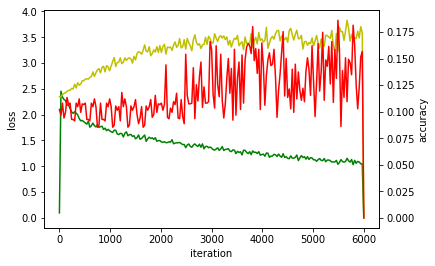

In [12]:
test_show(solverRoot0, 6000, 30, 30, 30)

### droppath Stage2
- stage2 load上一阶段训练出来的模型，网络的架构都是一样的，只是每个layer的drop out ratio不同
具有dropout组的实验，此时在每个block内部，由f3迭代出来的最左侧路径完全保留，f2迭代出来的最左侧路径drop的概率变成了0也被完全保留，f1层drop的概率为0.3。即此时，从顶向下的最短通路被保证得到了完全保留并仍在训练，最复杂的通路中（最长的路径）中通路被丢弃的概率为0.3。
- 此时的learning rate降为0.005。

snapshot found

plot the train loss and test accuracy



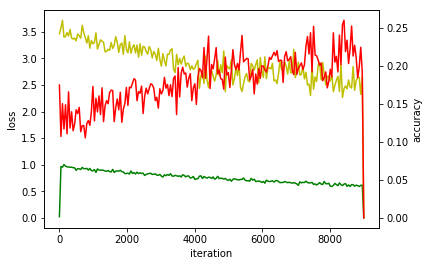

In [13]:
snapShot1 ='./phase0_iter_6000.solverstate.h5'
if os.path.isfile(snapShot1):
    print('snapshot found')
    
test_show(solverRoot1, 9000, 45, 45, 45,snapshot = snapShot1)

### droppath Stage3
- stage3 load上一阶段训练出来的模型，网络的架构仍然一样，只是每个layer的drop out ratio不同
具有dropout组的实验，此时在每个block内部，不存在droppath,即所有的神经元和层都跟随一起训练。
- learning rate 为0.0002

snapshot found

plot the train loss and test accuracy



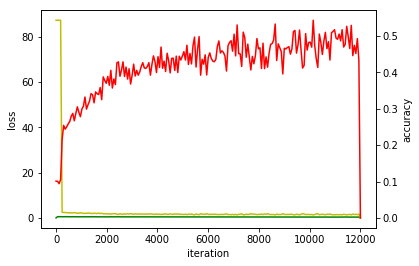

In [16]:
snapshot2 = 'phase1_iter_15000.solverstate.h5'
if os.path.isfile(snapshot2):
    print('snapshot found')
    
test_show(solverRoot2, 12000, 60, 60, 60,snapshot2)

### 非Dropout组 Stage1
- 对照组网络中不存在droppath,但是自顶向下每一个block内部每个层的神经元的drop概率逐渐递增，这个特性dropout组也有。
- learning rate 为0.001


plot the train loss and test accuracy



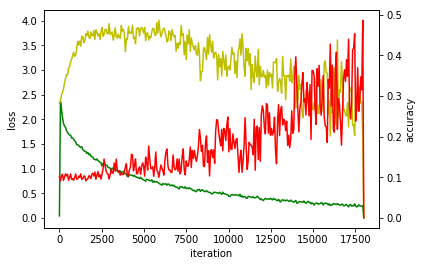

In [17]:
test_show(solverRoot3, 18000, 60, 60, 60)

### 非Dropout组 Stage2
加载模型，此时的learning rate由0.001变为0.0002

snapshot found

plot the train loss and test accuracy



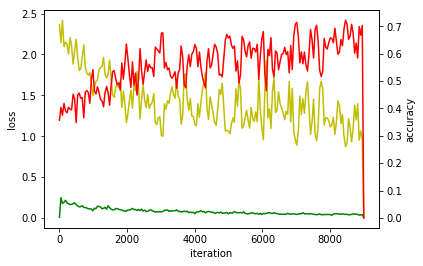

In [18]:
snapshot3 = 'phase3_iter_18000.solverstate.h5'
if os.path.isfile(snapshot3):
    print('snapshot found')
    
test_show(solverRoot4, 9000, 45, 45, 45,snapshot = snapshot3)

### Dropout组 Stage4
此时网络中已经不存在droppath,和stage3一致，是为了看到最终的收敛结果。

snapshot4 found

plot the train loss and test accuracy



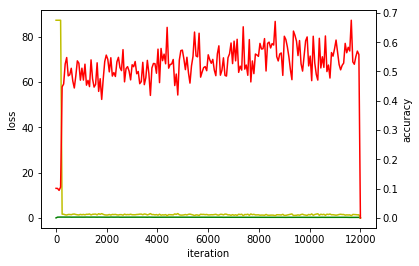

In [19]:
snapshot4 = 'phase2_iter_27000.solverstate.h5'
if os.path.isfile(snapshot3):
    print('snapshot4 found')
    
test_show(solverRoot2, 12000, 60, 60, 60,snapshot = snapshot4)

### 非Dropout组 Stage3
此时是为了看到最终的收敛结果。

snapshot found

plot the train loss and test accuracy



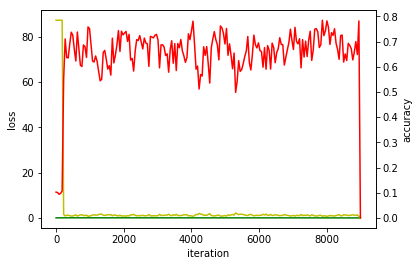

In [20]:
snapshot3 = 'phase3_iter_27000.solverstate.h5'
if os.path.isfile(snapshot3):
    print('snapshot found')
    
test_show(solverRoot4, 9000, 45, 45, 45,snapshot = snapshot3)

### 总结
实验组的网络实现了droppath功能，具体可以参照论文fig.3，
本次实验block个数由3变成了5，以至于直接拖累了计算的速度，使得每一百次迭代的时间从50s左右（block=3）变成了100s以上，这个影响非常明显。从具体的训练效率上看，两个网络都在27000次迭代的时候趋近于收敛，但是实现了droppath的网络每百次迭代的时间要少10-30s，这个特性可以在下一次的实验中体现出来。